<a href="https://www.kaggle.com/code/dalloliogm/beyond-autogluon?scriptVersionId=239248563" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Using Autogluon for this challenge

In this notebook I use the MultiModalPredictor function from Autogluon to predict the labels.

Autogluon can handle images, so let's see how does it fare with this challenge. 

In [1]:
# Install necessary libraries
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 16.2 MB/s eta 0

In [2]:
import os
def is_interactive():
   return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == "Interactive"
print("is interactive session?", is_interactive())
preset_quality = "medium_quality" if is_interactive() else "best_quality"

time_limit = 60 if is_interactive() else 3600

is interactive session? True


In [3]:
import autogluon.core as ag
#from autogluon import ImagePredictor
import pandas as pd
import os
import numpy as np
from autogluon.multimodal import MultiModalPredictor
from PIL import Image


2025-05-12 10:41:11.224200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747046471.465236      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747046471.533600      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Convert images to PNG

Autogluon doesn't read .npy images, so we save them as png.

Some images seem to be corrupted, or have a wrong shape. We'll skip them this time.

In [4]:

# Read the train.csv file that contains the labels
train_df = pd.read_csv('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/train.csv')

print(train_df.head())

               id  label
0   sample697.npy      7
1    sample54.npy     81
2  sample2270.npy      4
3  sample1401.npy     99
4  sample1901.npy     43


In [5]:
image_folder = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot"
# Define the output directory where you will save the images
output_dir = '/kaggle/working/hyperspectral_images/'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to load .npy files
def load_npy_image(image_name,
                  image_folder = "/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/ot/ot"):
    image_path = os.path.join(image_folder, image_name)
    image = np.load(image_path)
    return image

# Convert the .npy files to image files and save them
def save_image_from_npy(image_name, image_data,
                       output_dir = '/kaggle/working/hyperspectral_images/'
                       ):
    # Ensure image has correct dimensions (e.g., 128x128x125)
    if image_data.shape == (128, 128, 125):
        # Normalize the data to the range 0-255
        # Here, we'll just take the first band for simplicity
        image = image_data[:, :, 0]  # Extract the first band (change if you want to visualize different bands)
        image = np.clip(image, 0, 255)  # Clip values to valid image range
        image = image.astype(np.uint8)  # Convert to unsigned 8-bit integer type
        image_path = os.path.join(output_dir, image_name.replace('.npy', '.png'))
        # Convert numpy array to image using PIL
        pil_image = Image.fromarray(image)
        pil_image.save(image_path)
        #print(f"Saved {image_path}")
    else:
        print(f"Skipping {image_name} due to unexpected shape {image_data.shape}")

# Loop through the training data and save the images
for idx, row in train_df.iterrows():
    try:
        # Load the .npy image
        image = load_npy_image(row['id'])
        
        # Check the shape of the image and reshape if necessary
        save_image_from_npy(row['id'], image)
    
    except ValueError as e:
        print(f"Error loading {row['id']}: {e}")
        continue  # Skip the image and continue with the next one
        
# Map the image filenames to the new .png file paths
train_df['image_path'] = train_df['id'].apply(lambda x: os.path.join(output_dir, x.replace('.npy', '.png')))


Skipping sample2411.npy due to unexpected shape (128, 57, 125)
Skipping sample2143.npy due to unexpected shape (128, 57, 125)
Skipping sample1875.npy due to unexpected shape (128, 57, 125)
Skipping sample1071.npy due to unexpected shape (128, 57, 125)
Skipping sample736.npy due to unexpected shape (128, 57, 125)
Skipping sample602.npy due to unexpected shape (128, 57, 125)
Skipping sample133.npy due to unexpected shape (128, 57, 125)
Skipping sample2076.npy due to unexpected shape (128, 57, 125)
Skipping sample200.npy due to unexpected shape (128, 57, 125)
Error loading sample2451.npy: cannot reshape array of size 1785856 into shape (128,128,125)
Skipping sample669.npy due to unexpected shape (128, 57, 125)
Skipping sample2009.npy due to unexpected shape (128, 57, 125)
Skipping sample267.npy due to unexpected shape (128, 57, 125)
Skipping sample1339.npy due to unexpected shape (128, 57, 125)
Skipping sample468.npy due to unexpected shape (128, 57, 125)
Skipping sample1741.npy due to un

## EDA of this mysterious dataset

I can't make head or tails of this - some images are blank, yet they have high labels.

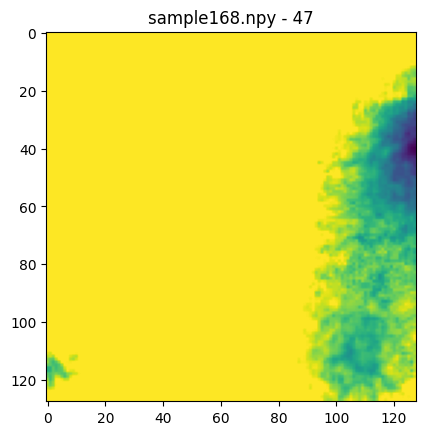

In [29]:
import matplotlib.pyplot as plt

def plot_image(train_df, row_id):
    img = Image.open(train_df.iloc[row_id,2])
    plt.imshow(img)
    plt.title(f"{train_df.iloc[row_id,0]} - {train_df.iloc[row_id,1]}")
plot_image(train_df, 6)

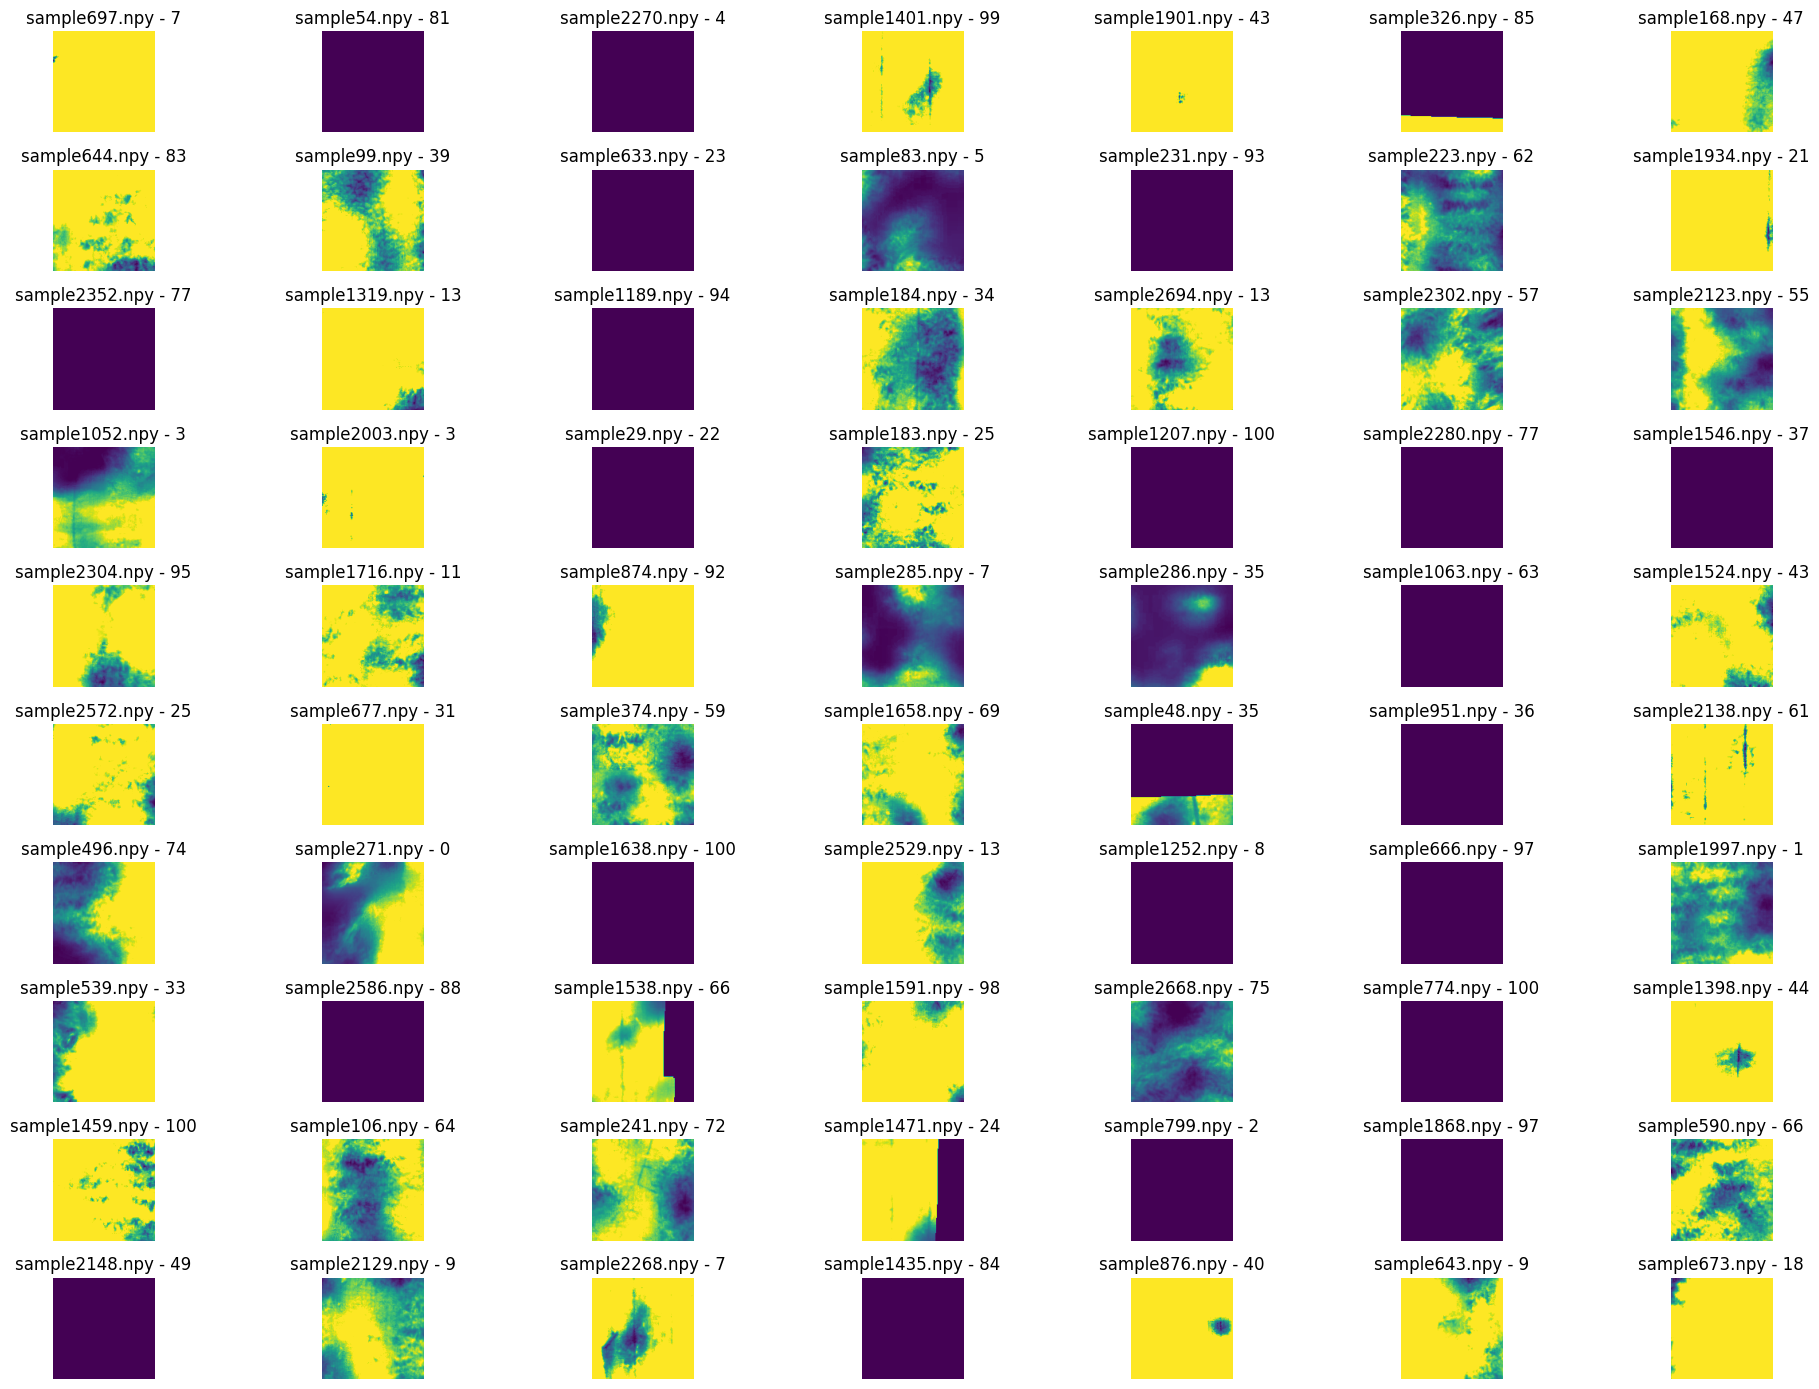

In [30]:
import matplotlib.pyplot as plt
from PIL import Image

# Define a function to plot images in a grid
def plot_images_in_grid(train_df, row_ids, grid_size=(10, 7)):
    # Create a figure with a specified size
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(20, 14))
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()
    
    # Loop through the row_ids and plot images
    for i, row_id in enumerate(row_ids):
        img = Image.open(train_df.iloc[row_id, 2])  # Load the image from the path
        axes[i].imshow(img)  # Display the image
        axes[i].set_title(f"{train_df.iloc[row_id, 0]} - {train_df.iloc[row_id, 1]}")
        axes[i].axis('off')  # Turn off the axis to keep the image clean
    
    # Adjust the layout to prevent overlapping titles and images
    plt.tight_layout()
    plt.show()

# Example usage:
# Choose the first 70 row IDs for plotting
row_ids = list(range(70))

# Call the function to plot the images
plot_images_in_grid(train_df, row_ids, grid_size=(10, 7))  # Adjust grid_size as needed


In [7]:
# Now the dataframe has 'image_path' and 'label' columns
# Preview the updated dataframe
print(train_df.head())

train_df.iloc[0,2]


               id  label                                         image_path
0   sample697.npy      7  /kaggle/working/hyperspectral_images/sample697...
1    sample54.npy     81  /kaggle/working/hyperspectral_images/sample54.png
2  sample2270.npy      4  /kaggle/working/hyperspectral_images/sample227...
3  sample1401.npy     99  /kaggle/working/hyperspectral_images/sample140...
4  sample1901.npy     43  /kaggle/working/hyperspectral_images/sample190...


'/kaggle/working/hyperspectral_images/sample697.png'

In [8]:
!ls /kaggle/working/hyperspectral_images/sample697.png

/kaggle/working/hyperspectral_images/sample697.png


## Running Autogluon prediction

In [9]:
from autogluon.multimodal import MultiModalPredictor
#from autogluon.vision import ImagePredictor

# Initialize AutoGluon MultiModalPredictor with label column name
predictor = MultiModalPredictor(label="label")

# Perform k-fold cross-validation (e.g., 5-fold)
cv_results = predictor.fit(
    train_data=train_df.drop(columns="id"),
    time_limit=time_limit,
#    num_bagging_folds=5,  # Number of folds for cross-validation
#    num_bagging_sets=1,   # Number of models to be trained per fold
    save_space=True,
    presets=preset_quality
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250512_104234"
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Pytorch Version:    2.5.1+cu124
CUDA Version:       CUDA is not available
Memory Avail:       29.41 GB / 31.35 GB (93.8%)
Disk Space Avail:   19.49 GB / 19.52 GB (99.9%)
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 101) unique label values:  [7, 81, 4, 99, 43, 85, 47, 83, 39, 23]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/dat

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/utils/precision.py:71: UserWarning: Only CPU is detected in the instance. This may result in slow speed for MultiModalPredictor. Consider using an instance with GPU support.
  warnings.warn(
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 4.3 M  | train
1 | validation_metric | MulticlassAccuracy              | 0      | train
2 | loss_func         | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.326    Total estimated model params size

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 6: 'val_accuracy' reached 0.01376 (best 0.01376), saving model to '/kaggle/working/AutogluonModels/ag-20250512_104234/epoch=0-step=6.ckpt' as top 3
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/kaggle/working/AutogluonModels/ag-20250512_104234")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




### Plotting CV scores

In [10]:
cv_results.fit_summary()

{'val_accuracy': 0.013761468231678009, 'training_time': 71.7716817855835}

## Predicting and creating submission

In [11]:
test_df = pd.read_csv('/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2025/test.csv')

# Loop through the training data and save the images
for idx, row in test_df.iterrows():
    try:
        # Load the .npy image
        image = load_npy_image(row['id'])
        
        # Check the shape of the image and reshape if necessary
        save_image_from_npy(row['id'], image)
    
    except ValueError as e:
        print(f"Error loading {row['id']}: {e}")
        continue  # Skip the image and continue with the next one


test_df

Skipping sample2520.npy due to unexpected shape (128, 57, 125)
Skipping sample1406.npy due to unexpected shape (128, 57, 125)
Skipping sample870.npy due to unexpected shape (128, 57, 125)
Skipping sample66.npy due to unexpected shape (128, 57, 125)
Skipping sample401.npy due to unexpected shape (128, 57, 125)
Skipping sample1138.npy due to unexpected shape (128, 57, 125)
Skipping sample2210.npy due to unexpected shape (128, 57, 125)
Skipping sample1540.npy due to unexpected shape (128, 57, 125)
Skipping sample2721.npy due to unexpected shape (128, 57, 125)


,id
0,sample1957.npy
1,sample1369.npy
2,sample782.npy
3,sample2255.npy
4,sample2160.npy
...,...
540,sample1313.npy
541,sample1656.npy
542,sample760.npy
543,sample718.npy


In [12]:
      
# Map the image filenames to the new .png file paths
test_df['image_path'] = test_df['id'].apply(lambda x: os.path.join(output_dir, x.replace('.npy', '.png')))

In [13]:
test_df

,id,image_path
0,sample1957.npy,/kaggle/working/hyperspectral_images/sample195...
1,sample1369.npy,/kaggle/working/hyperspectral_images/sample136...
2,sample782.npy,/kaggle/working/hyperspectral_images/sample782...
3,sample2255.npy,/kaggle/working/hyperspectral_images/sample225...
4,sample2160.npy,/kaggle/working/hyperspectral_images/sample216...
...,...,...
540,sample1313.npy,/kaggle/working/hyperspectral_images/sample131...
541,sample1656.npy,/kaggle/working/hyperspectral_images/sample165...
542,sample760.npy,/kaggle/working/hyperspectral_images/sample760...
543,sample718.npy,/kaggle/working/hyperspectral_images/sample718...


In [14]:
!ls /kaggle/working/hyperspectral_images/sample1957.*

/kaggle/working/hyperspectral_images/sample1957.png


In [15]:
# Make predictions using the trained AutoGluon model
# Ensure we're passing the entire DataFrame, not just the image paths column
predictions = predictor.predict(test_df[['image_path']])

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'ID': test_df['id'],  # The IDs from the test.csv
    'label': predictions   # The predicted labels from the model
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

# Optionally, show the first few rows of the submission file
print(submission_df.head())


/usr/local/lib/python3.11/dist-packages/autogluon/multimodal/data/infer_types.py:248: UserWarning: Among 500 sampled images in column 'image_path', 2% images can't be open. You may need to thoroughly check your data to see the percentage of missing images, and estimate the potential influence. By default, we use an image with zero pixels. You can also set hyperparameter 'data.image.missing_value_strategy' to be 'skip', which skips samples that contain a missing image.
  warnings.warn(
INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

               ID  label
0  sample1957.npy      2
1  sample1369.npy      1
2   sample782.npy      9
3  sample2255.npy     30
4  sample2160.npy     19


## Visualizing predictions

The distribution of predicted labels seems very different compared to the train, so I don't expect this prediction to have a great leaderboard score.

In [16]:
!ls 

AutogluonModels  hyperspectral_images  submission.csv


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'distribution of labels in Train')

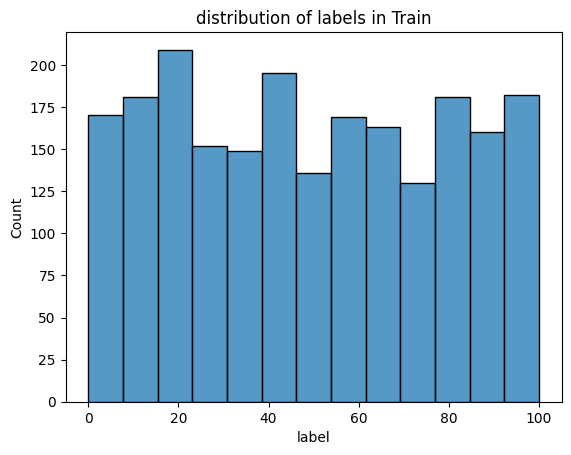

In [17]:
import seaborn as sns
sns.histplot(data=train_df, x="label").set_title("distribution of labels in Train")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'distribution of predicted labels')

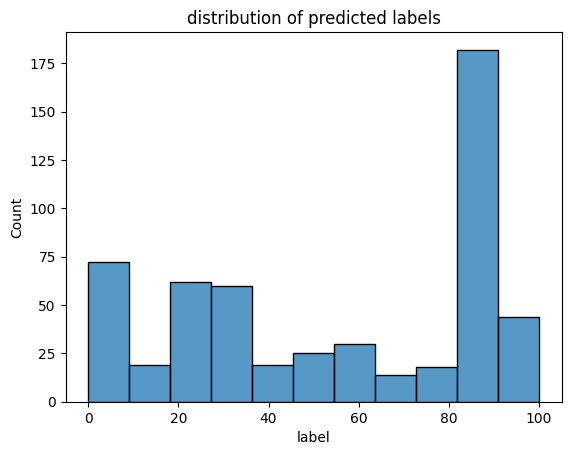

In [18]:
import seaborn as sns
sns.histplot(data=submission_df, x="label").set_title("distribution of predicted labels")
